In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 3.6 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import random
import plotly.express as px

In [ ]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyunpack import Archive
Archive('/content/drive/MyDrive/Colab Notebooks/Final_year_project/Latest_4_2_23.rar').extractall('/content')

In [ ]:
train_dir = Path("/content/output/train")
train_filepaths = list(train_dir.glob(r'**/*.*'))

test_dir = Path(("/content/output/test"))
test_filepaths = list(test_dir.glob(r'**/*.*'))

val_dir = Path(("/content/output/val"))
val_filepaths = list(test_dir.glob(r'**/*.*'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1070

Number of different labels: 11

Labels: ['foxglove' 'Abrus precatorius' 'castor_oil_plant' 'lilies' 'wisteria'
 'dieffenbachia' 'lily_of_the_valley' 'oleander' 'pothos' 'rhubarb'
 'Madagascar periwinkle']


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1066 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

pretrained_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 9.1059 - accuracy: 0.1295
Epoch 1: val_loss improved from inf to 2.22737, saving model to /content/model/model.h5
34/34 [==============================] - 52s 1s/step - loss: 9.1059 - accuracy: 0.1295 - val_loss: 2.2274 - val_accuracy: 0.3566 - lr: 1.0000e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 3.2312 - accuracy: 0.2430
Epoch 2: val_loss improved from 2.22737 to 1.79238, saving model to /content/model/model.h5
34/34 [==============================] - 39s 1s/step - loss: 3.2312 - accuracy: 0.2430 - val_loss: 1.7924 - val_accuracy: 0.4196 - lr: 1.0000e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 2.3863 - accuracy: 0.3358
Epoch 3: val_loss improved from 1.79238 to 1.74853, saving model to /content/model/model.h5
34/34 [==============================] - 25s 744ms/step - loss: 2.3863 - accuracy: 0.3358 - val_loss: 1.7485 - val_accuracy: 0.4476 - lr: 1.0000e-04
Epoch

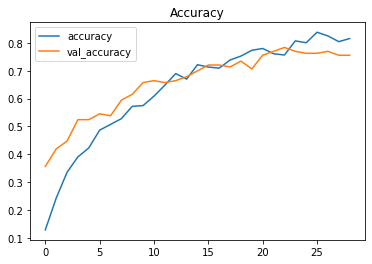

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

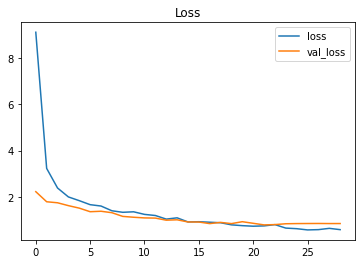

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

5/5 [==============================] - 4s 627ms/step


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 76.92%


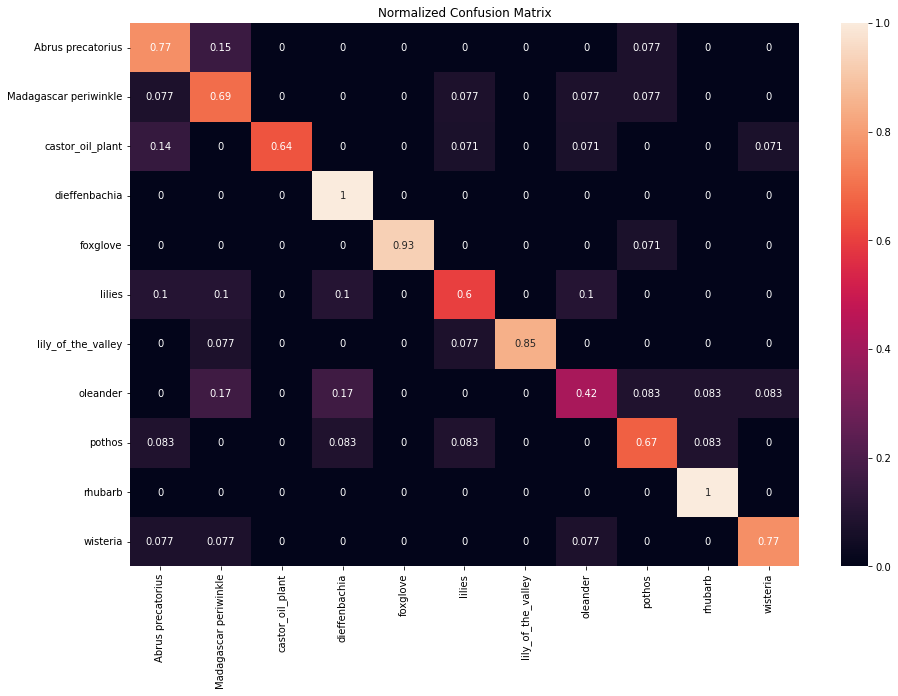

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

**MobileNetV2**

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1066 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 2.3524 - accuracy: 0.2402
Epoch 1: val_loss improved from inf to 1.46768, saving model to /content/model/model.h5
34/34 [==============================] - 31s 810ms/step - loss: 2.3524 - accuracy: 0.2402 - val_loss: 1.4677 - val_accuracy: 0.6224 - lr: 1.0000e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.5285 - accuracy: 0.4728
Epoch 2: val_loss improved from 1.46768 to 1.03034, saving model to /content/model/model.h5
34/34 [==============================] - 26s 783ms/step - loss: 1.5285 - accuracy: 0.4728 - val_loss: 1.0303 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1.1616 - accuracy: 0.6013
Epoch 3: val_loss improved from 1.03034 to 0.81695, saving model to /content/model/model.h5
34/34 [==============================] - 27s 795ms/step - loss: 1.1616 - accuracy: 0.

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

5/5 [==============================] - 3s 443ms/step


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 83.22%


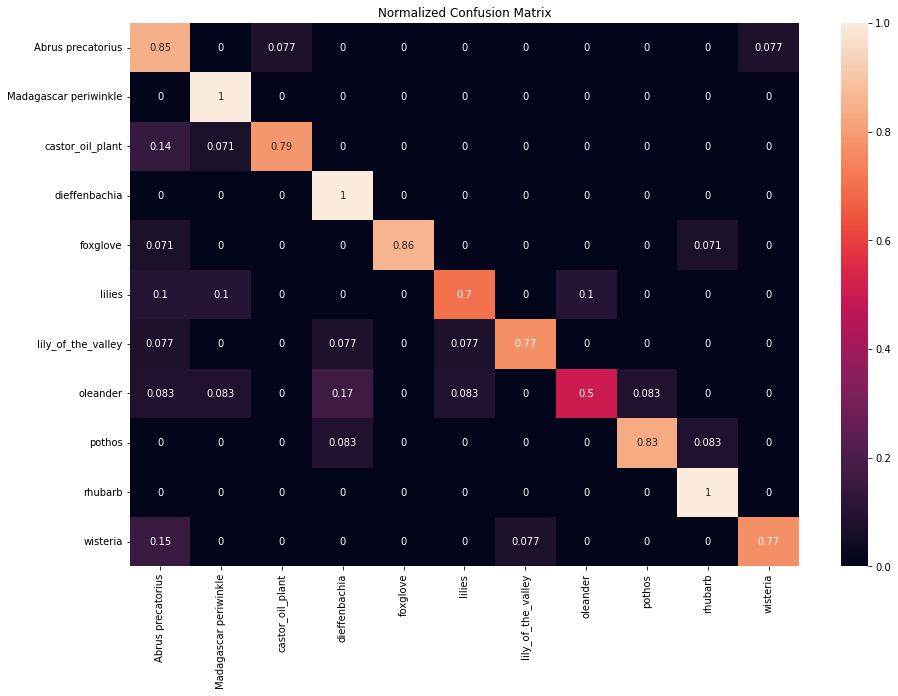

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

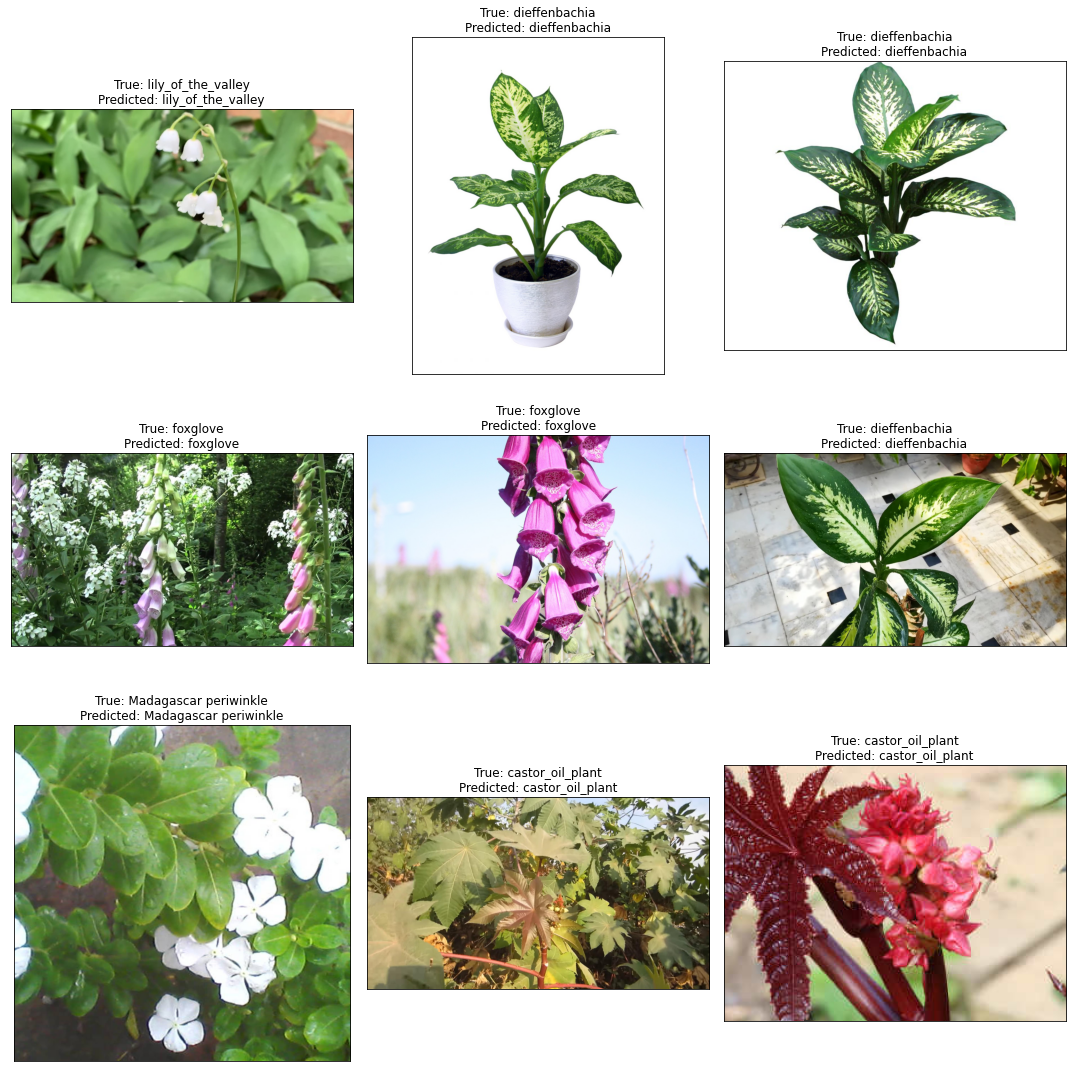

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

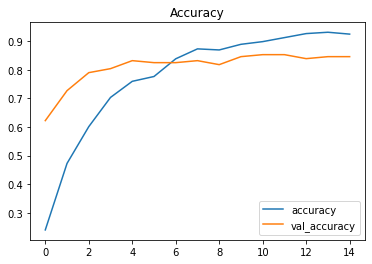

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

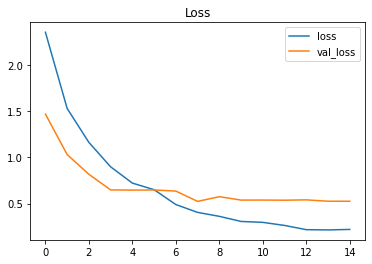

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

**Xception**

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1066 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

pretrained_model = tf.keras.applications.Xception(
    input_shape=(299, 299, 3),
    include_top=False,
    weights='imagenet',
)


for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 2.0047 - accuracy: 0.3133
Epoch 1: val_loss improved from inf to 1.08680, saving model to /content/model/model.h5
34/34 [==============================] - 52s 1s/step - loss: 2.0047 - accuracy: 0.3133 - val_loss: 1.0868 - val_accuracy: 0.7133 - lr: 1.0000e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.2775 - accuracy: 0.5741
Epoch 2: val_loss improved from 1.08680 to 0.86517, saving model to /content/model/model.h5
34/34 [==============================] - 34s 1s/step - loss: 1.2775 - accuracy: 0.5741 - val_loss: 0.8652 - val_accuracy: 0.7622 - lr: 1.0000e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.9539 - accuracy: 0.6773
Epoch 3: val_loss improved from 0.86517 to 0.60888, saving model to /content/model/model.h5
34/34 [==============================] - 32s 936ms/step - loss: 0.9539 - accuracy: 0.6773

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]

5/5 [==============================] - 4s 683ms/step


In [ ]:

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 89.51%


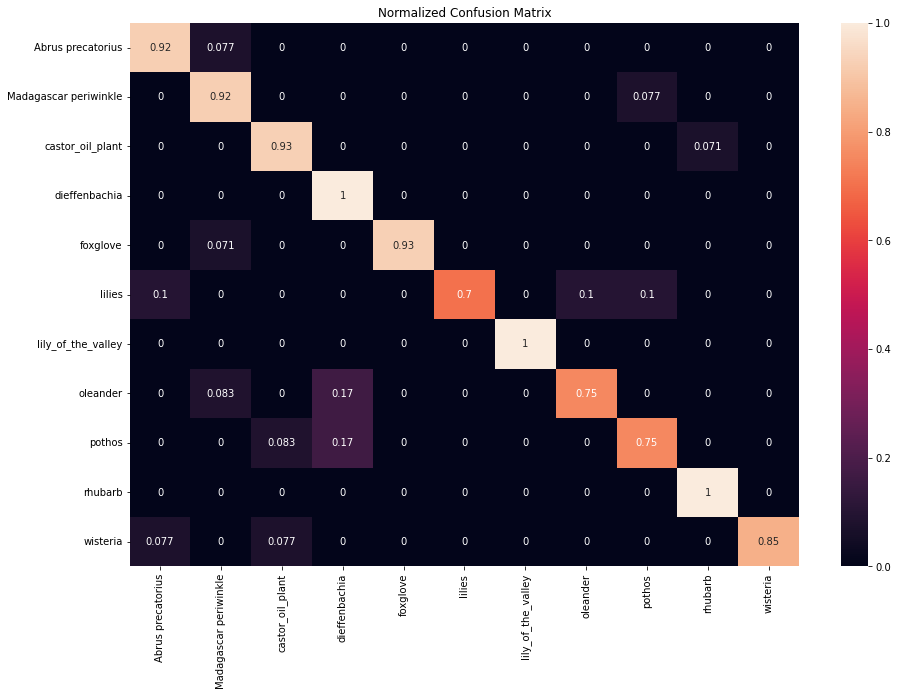

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

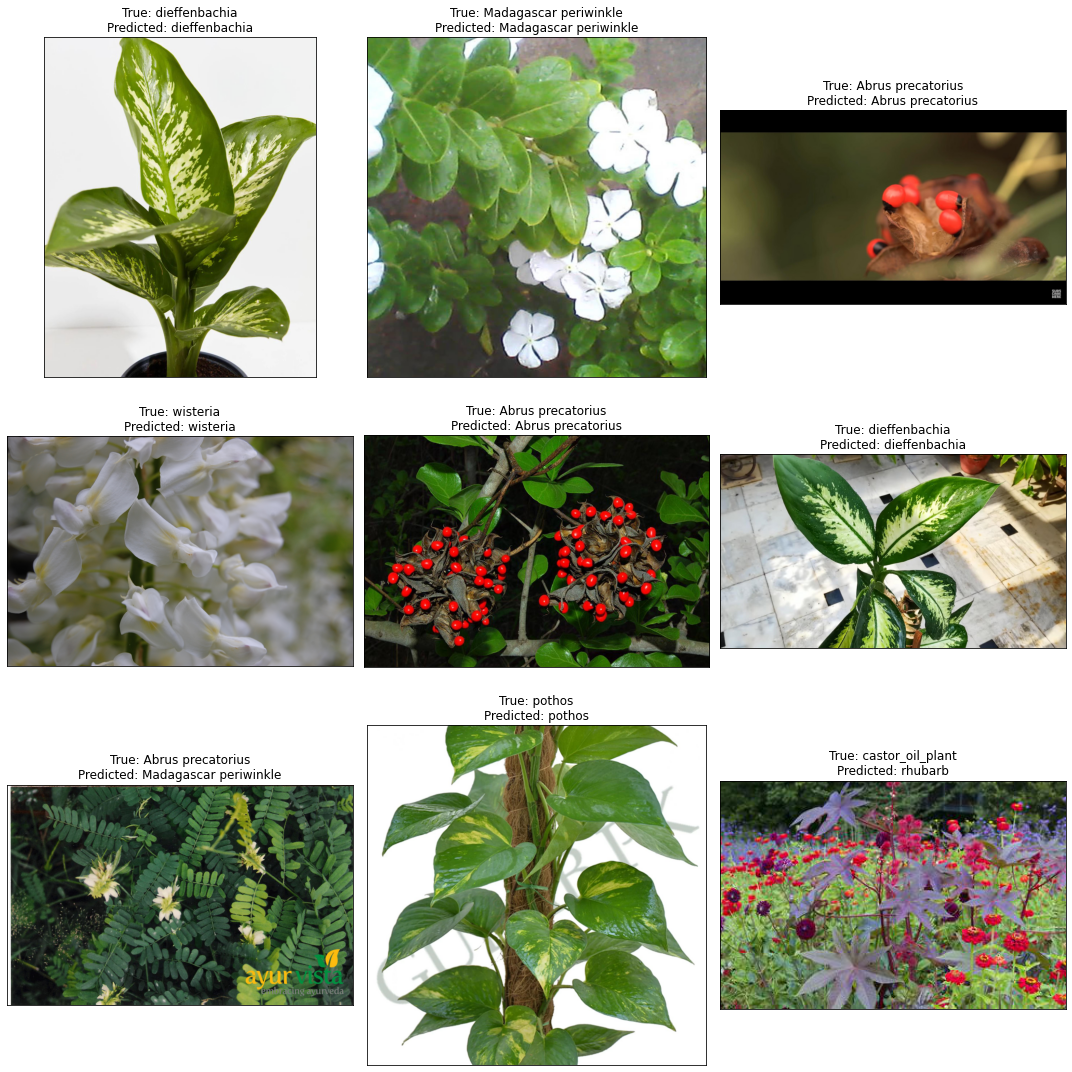

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

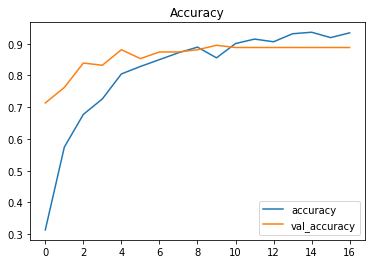

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

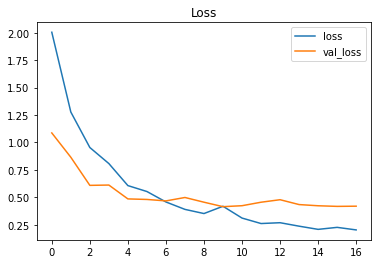

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

**EfficientNetV2B3**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetV2B3

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(300, 300),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = test_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(300, 300),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(300, 300),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 1066 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3

pretrained_model = EfficientNetV2B3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


52606240/52606240 [==============================] - 0s 0us/step
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 2.3504 - accuracy: 0.1679
Epoch 1: val_loss improved from inf to 2.17259, saving model to /content/model/model.h5
67/67 [==============================] - 51s 451ms/step - loss: 2.3504 - accuracy: 0.1679 - val_loss: 2.1726 - val_accuracy: 0.4615 - lr: 1.0000e-04
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 2.0994 - accuracy: 0.3565
Epoch 2: val_loss improved from 2.17259 to 1.89366, saving model to /content/model/model.h5
67/67 [==============================] - 27s 395ms/step - loss: 2.0994 - accuracy: 0.3565 - val_loss: 1.8937 - val_accuracy: 0.5874 - lr: 1.0000e-04
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.8987 - accuracy: 0.4250
Epoch 3: val_loss improved from 1.89366 to 1.58813, saving model to /content/model/model.h5
67/67 [==============================] - 26s 385ms/step - loss: 1.8987 - accuracy: 

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]

9/9 [==============================] - 3s 345ms/step
{'Abrus precatorius': 0, 'Madagascar periwinkle': 1, 'castor_oil_plant': 2, 'dieffenbachia': 3, 'foxglove': 4, 'lilies': 5, 'lily_of_the_valley': 6, 'oleander': 7, 'pothos': 8, 'rhubarb': 9, 'wisteria': 10}


In [ ]:

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 93.01%


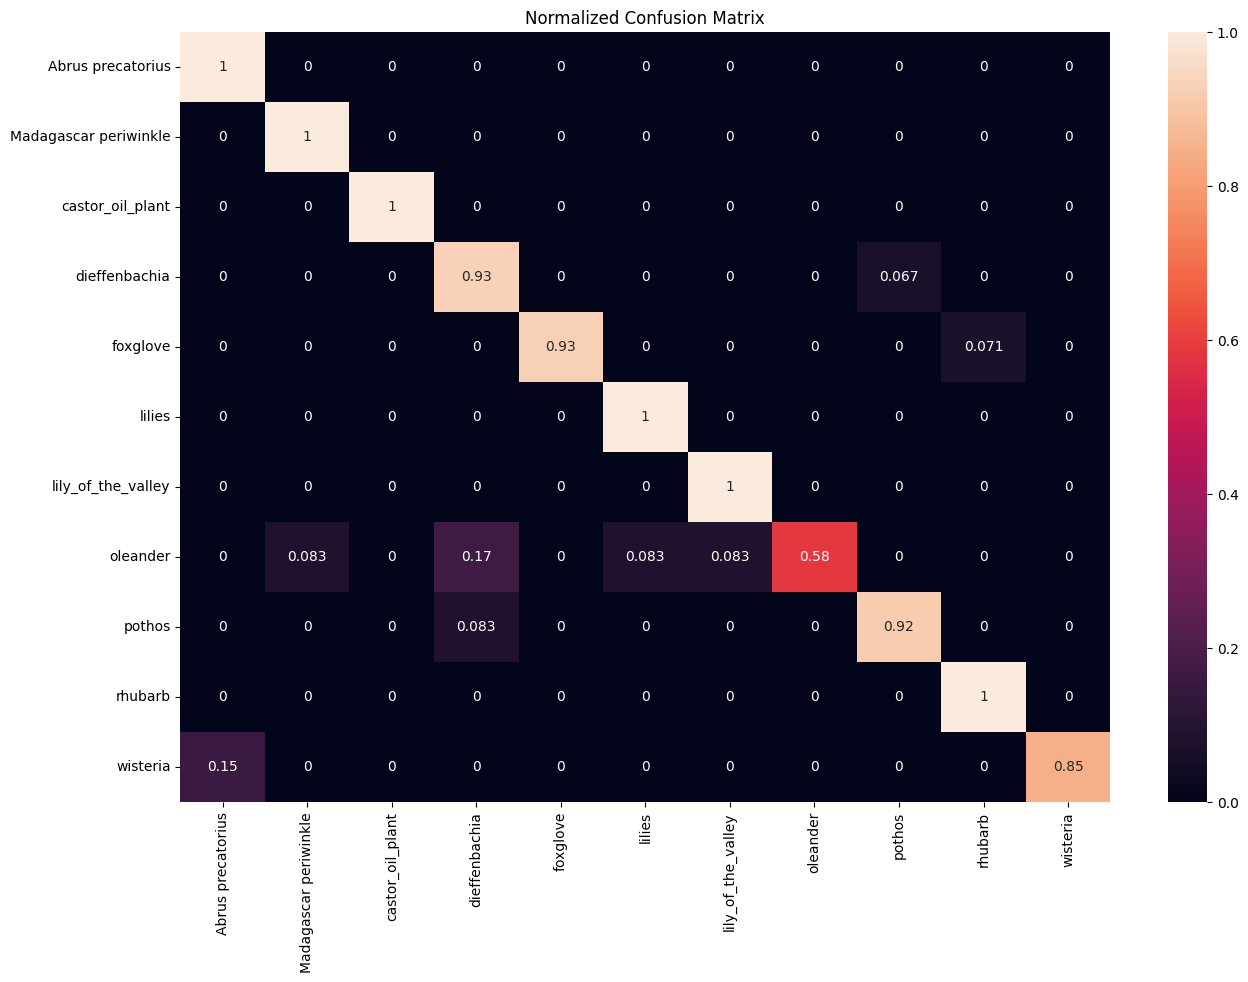

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

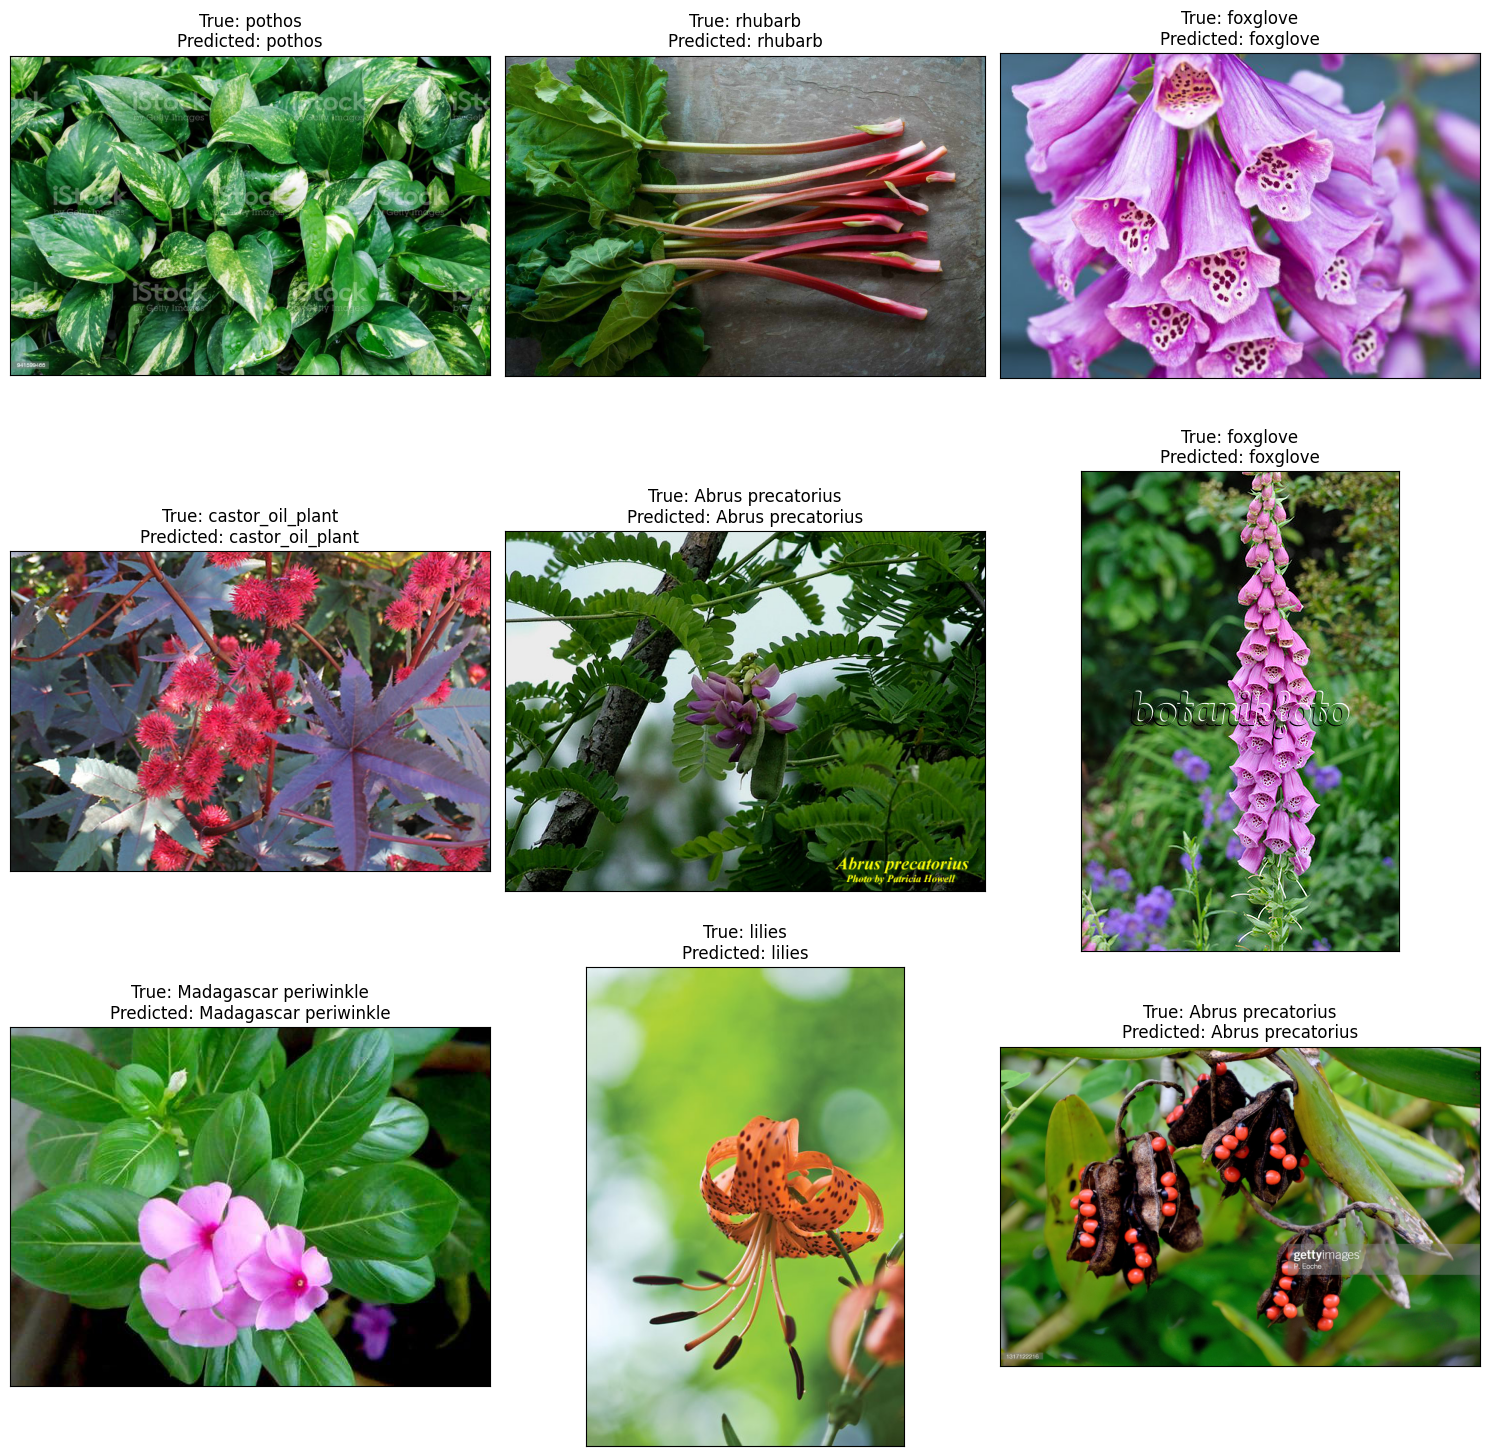

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

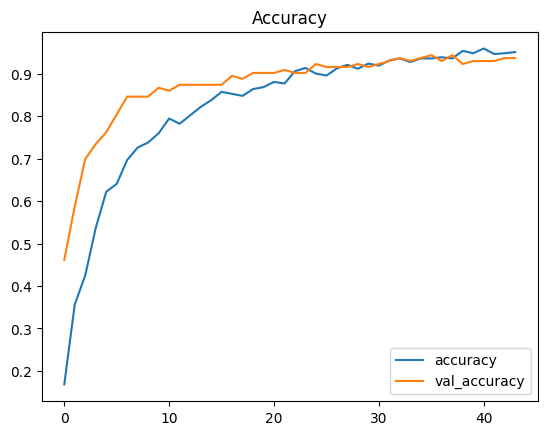

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

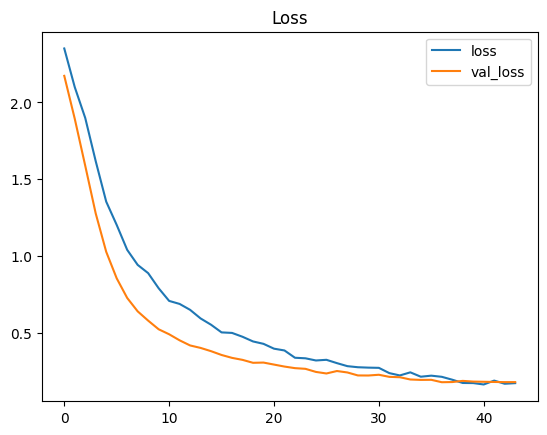

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

**RESENET50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  # ResNet50 requires (224, 224) input size
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = test_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 1066 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.
Found 143 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 2.4766 - accuracy: 0.1670
Epoch 1: val_loss improved from inf to 1.94245, saving model to /content/model/model.h5
67/67 [==============================] - 35s 449ms/step - loss: 2.4766 - accuracy: 0.1670 - val_loss: 1.9425 - val_accuracy: 0.4755 - lr: 1.0000e-04
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 2.0083 - accuracy: 0.3039
Epoch 2: val_loss improved from 1.94245 to 1.60365, saving model to /content/model/model.h5
67/67 [==============================] - 28s 416ms/step - loss: 2.0083 - accuracy: 0.3039 - val_loss: 1.6037 - val_accuracy: 0.5944 - lr: 1.0000e-04
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.7129 - accuracy: 0.4362
Epoch 3: val_loss improved from 1.60365 to 1.29271, saving model to /content/model/model.h5
67/67 [==============================] - 28s 412ms/step - loss: 1.7129 - accuracy: 

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]

9/9 [==============================] - 3s 253ms/step


In [ ]:

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 90.21%


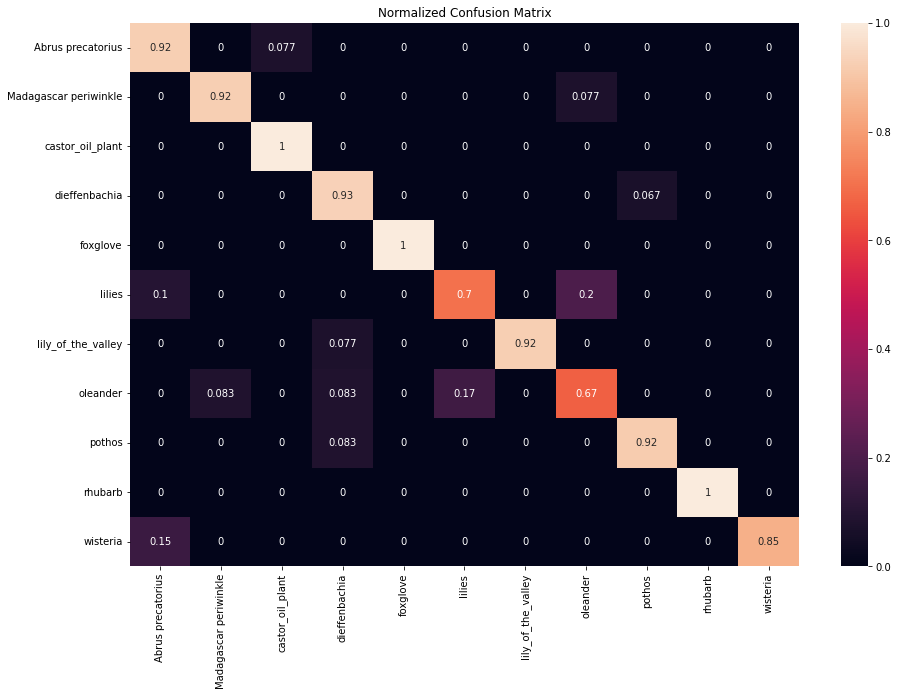

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

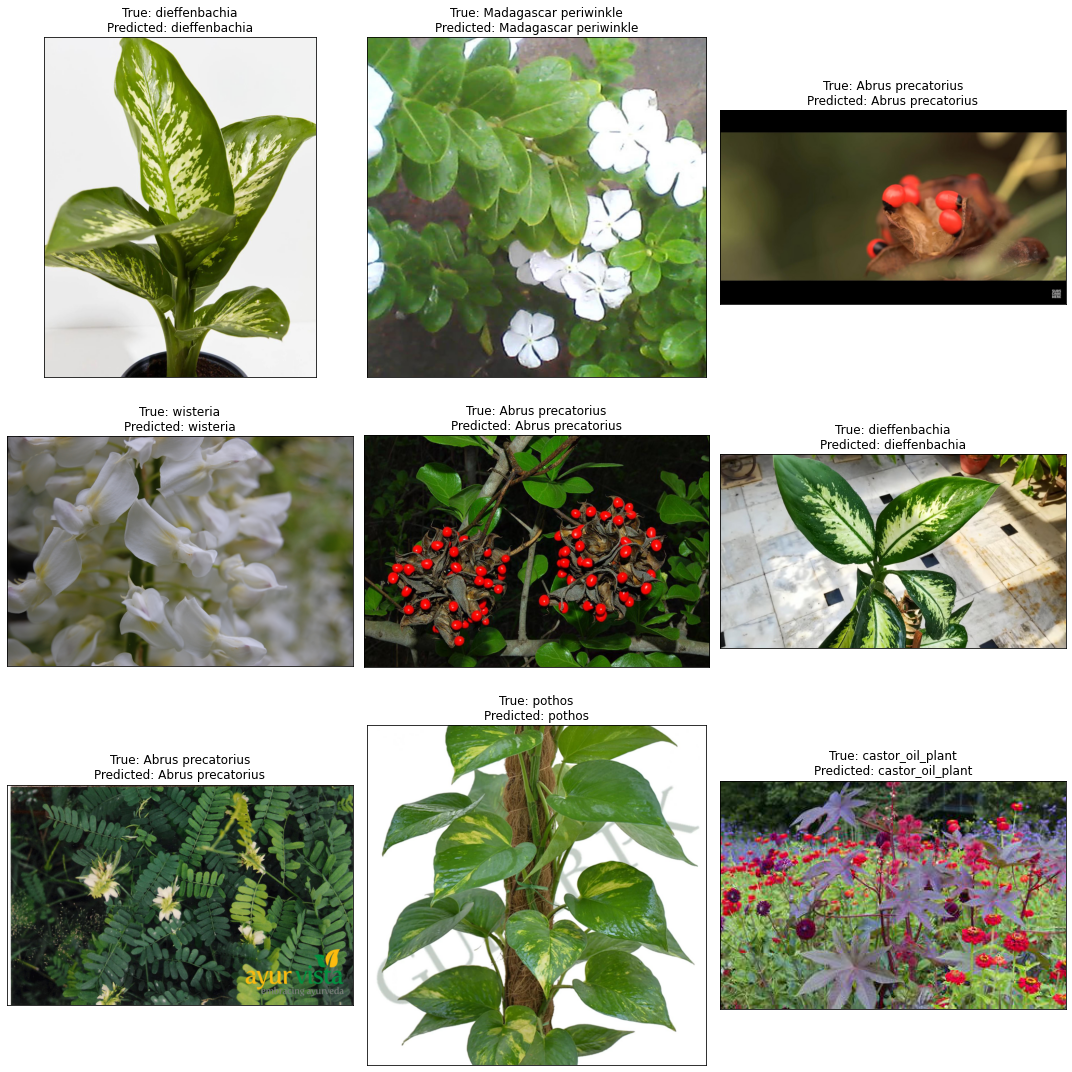

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

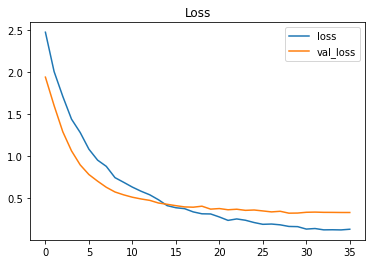

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

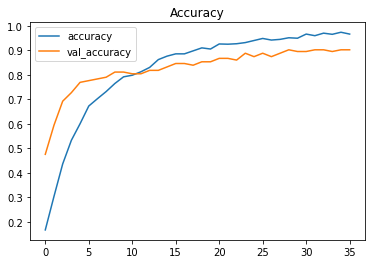

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()